In [2]:
%pylab nbagg
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Load dataset
file_path = '../data/hd-EEG/values_metrics_hd_eeg.csv'
df = pd.read_csv(file_path)

In [4]:
blue_color = plt.cm.Blues(0.6)

In [5]:
df = (
    df.drop(columns=["radius"])  # remove radius
      .rename(columns={
          "sub": "participant",
          "run or session": "session",
          "trial": "trial",
          "metric": "metric",
          "pre_value": "pre_value",
          "post_value": "post_value"
      })
)

In [6]:
df

,participant,session,trial,metric,pre_value,post_value
0,1,1,1,mean_data,4.940390e-08,3.191138e-07
1,1,1,1,var_data,2.972330e-11,5.753842e-11
2,1,1,1,mean_var_data,2.971358e-11,3.828657e-11
3,1,1,1,var_mean_data,9.719754e-15,1.925185e-11
4,1,1,1,var_var_data,3.279134e-23,3.390518e-22
...,...,...,...,...,...,...
2506370,36,10,12,Entropy_DFC,2.188748e+00,2.862571e+00
2506371,36,10,12,Entropy_PLV,-2.783887e+16,-2.095781e+16
2506372,36,10,12,Entropy_AEC,1.763450e+00,2.423633e+00
2506373,36,10,12,Entropy_COKU,1.602641e+00,1.991815e+00


In [7]:
# List of metrics to keep
metrics_to_keep = [
    "salience",
    "max_dynamic_network_profile",
    "plv_matrix_mean_mat",
    "dynamic_functional_connectivity_matrix_var_mat",
    "Entropy_FC"
]

# Filter dataset
df = df[df["metric"].isin(metrics_to_keep)].reset_index(drop=True)


In [8]:
df

,participant,session,trial,metric,pre_value,post_value
0,1,1,1,salience,0.723476,0.801978
1,1,1,1,max_dynamic_network_profile,2.894258,2.331435
2,1,1,1,dynamic_functional_connectivity_matrix_var_mat,0.115644,0.047008
3,1,1,1,plv_matrix_mean_mat,0.736866,0.413825
4,1,1,1,Entropy_FC,0.316690,1.805688
...,...,...,...,...,...,...
100250,36,10,12,salience,0.917898,0.702332
100251,36,10,12,max_dynamic_network_profile,2.536030,2.348489
100252,36,10,12,dynamic_functional_connectivity_matrix_var_mat,0.079548,0.052123
100253,36,10,12,plv_matrix_mean_mat,0.575225,0.393983


In [9]:
df_filtered=df

# STD

In [10]:
from scipy.stats import wilcoxon

# ------------------------------------------------------------
# STEP 1. Variability (STD) across trials
# ------------------------------------------------------------
df_variability_std = (
    df_filtered
    .groupby(["participant", "session", "metric"])
    .agg(
        STD_pre=("pre_value", "std"),
        STD_post=("post_value", "std")
    )
    .reset_index()
)

# ------------------------------------------------------------
# STEP 2. Conditioning analysis (Q1 vs Random) with STD
# ------------------------------------------------------------
pre_metric = metrics_to_keep[1]
post_metric = metrics_to_keep[1]

results = []
for (participant, session), df_group in df_filtered.groupby(["participant", "session"]):

    pre_vals = df_group[df_group["metric"] == pre_metric][["trial", "pre_value"]]
    post_vals = df_group[df_group["metric"] == post_metric][["trial", "post_value"]]

    merged = pd.merge(pre_vals, post_vals, on="trial", suffixes=("_pre", "_post"))
    if merged.empty:
        continue

    # Full STD
    std_full = merged["post_value"].std()
    if std_full == 0 or np.isnan(std_full):
        continue

    # Q1 subset
    q1_thr = merged["pre_value"].quantile(0.25)
    subset_q1 = merged[merged["pre_value"] <= q1_thr]
    if len(subset_q1) <= 1:
        continue
    std_q1 = subset_q1["post_value"].std()

    # Random subset
    rand_subset = merged.sample(n=len(subset_q1), random_state=0)
    std_rand = rand_subset["post_value"].std()

    rel_q1 = std_q1 / std_full * 100
    rel_rand = std_rand / std_full * 100

    results.append({
        "participant": participant,
        "session": session,
        "post_metric": post_metric,
        "pre_metric": pre_metric,
        "n_trials_Q1": len(subset_q1),
        "RelSpread_Q1": rel_q1,
        "RelSpread_Random": rel_rand,
        "DeltaPerc_Q1_vs_Random": rel_q1 - rel_rand
    })

df_spread_std = pd.DataFrame(results)

# Wilcoxon test
stat, pval = wilcoxon(df_spread_std["DeltaPerc_Q1_vs_Random"].dropna())

# ------------------------------------------------------------
# STEP 1. Variability (STD) across trials
# ------------------------------------------------------------
df_variability_std = (
    df_filtered
    .groupby(["participant", "session", "metric"])
    .agg(
        STD_pre=("pre_value", "std"),
        STD_post=("post_value", "std")
    )
    .reset_index()
)

# Metric titles
metric_titles = {
    "salience": "Salience",
    "max_dynamic_network_profile": "Peak Synchrony",
    "plv_matrix_mean_mat": "Entrainment",
    "dynamic_functional_connectivity_matrix_var_mat": "Fluidity",
    "Entropy_FC": "Complexity"
}


import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Ordered metrics
ordered_metrics = ["salience", 
                   "max_dynamic_network_profile", 
                   "plv_matrix_mean_mat", 
                   "dynamic_functional_connectivity_matrix_var_mat", 
                   "Entropy_FC"]

ordered_titles = ["Salience", "Peak Synchrony", "Entrainment", "Fluidity", "Complexity"]

# ------------------------------------------------------------
# Build matrix of mean Δ% spread (Q1 - Random) for each pre/post pair (using STD)
# ------------------------------------------------------------
mat = np.zeros((len(ordered_metrics), len(ordered_metrics)))

for i, pre_metric in enumerate(ordered_metrics):
    for j, post_metric in enumerate(ordered_metrics):
        results = []
        for (participant, session), df_group in df_filtered.groupby(["participant", "session"]):

            # Extract relevant trials
            pre_vals = df_group[df_group["metric"] == pre_metric][["trial", "pre_value"]]
            post_vals = df_group[df_group["metric"] == post_metric][["trial", "post_value"]]

            merged = pd.merge(pre_vals, post_vals, on="trial", suffixes=("_pre", "_post"))
            if merged.empty:
                continue

            # Full STD
            std_full = merged["post_value"].std()
            if std_full == 0 or np.isnan(std_full):
                continue

            # Q1 subset
            q1_thr = merged["pre_value"].quantile(0.25)
            subset_q1 = merged[merged["pre_value"] <= q1_thr]
            if len(subset_q1) <= 1:
                continue
            std_q1 = subset_q1["post_value"].std()

            # Random subset
            rand_subset = merged.sample(n=len(subset_q1), random_state=0)
            std_rand = rand_subset["post_value"].std()

            # Normalize to full
            rel_q1 = std_q1 / std_full * 100
            rel_rand = std_rand / std_full * 100

            results.append(rel_q1 - rel_rand)

        # Mean Δ% across subjects/sessions
        mat[i, j] = np.nanmean(results) if len(results) > 0 else np.nan

In [11]:
from scipy.stats import wilcoxon, ttest_rel
import pandas as pd

# For each metric separately
results = []
for metric, df_m in df_variability_std.groupby("metric"):
    diffs = df_m["STD_post"] - df_m["STD_pre"]

    # Non-parametric paired test (robust for non-normal distributions)
    stat_w, p_w = wilcoxon(df_m["STD_post"], df_m["STD_pre"])

    # Parametric paired t-test (if differences are approx. normal)
    stat_t, p_t = ttest_rel(df_m["STD_post"], df_m["STD_pre"])

    results.append({
        "metric": metric,
        "mean_pre": df_m["STD_pre"].mean(),
        "mean_post": df_m["STD_post"].mean(),
        "mean_diff": diffs.mean(),
        "wilcoxon_stat": stat_w,
        "wilcoxon_p": p_w,
        "ttest_stat": stat_t,
        "ttest_p": p_t,
        "n_pairs": len(df_m)
    })

df_stats = pd.DataFrame(results)
print(df_stats)


                                           metric  mean_pre  mean_post  \
0                                      Entropy_FC  0.541942   0.139060   
1  dynamic_functional_connectivity_matrix_var_mat  0.031384   0.007309   
2                     max_dynamic_network_profile  2.404819   1.469776   
3                             plv_matrix_mean_mat  0.136721   0.033063   
4                                        salience  0.216991   0.150364   

   mean_diff  wilcoxon_stat    wilcoxon_p  ttest_stat        ttest_p  n_pairs  
0  -0.402881            0.0  3.258867e-54  -73.253167  1.370710e-201      320  
1  -0.024076            0.0  3.258867e-54  -70.489133  1.433683e-196      320  
2  -0.935043         2173.0  1.025583e-45  -17.767465   1.402217e-49      320  
3  -0.103658            0.0  3.258867e-54  -64.985309  4.872300e-186      320  
4  -0.066627         2269.0  2.340098e-45  -20.733996   4.501715e-61      320  


# Figure 3

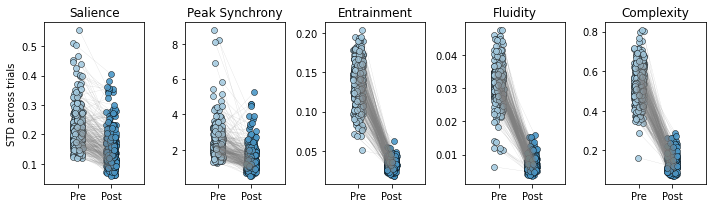

In [12]:
# ------------------------------------------------------------
# Plot Pre vs Post STD per metric
# ------------------------------------------------------------
colors = [plt.cm.Blues(0.35),plt.cm.Blues(0.6)]

fig, axes = plt.subplots(1, len(metric_titles), figsize=(10, 3), sharey=False)

for i, (ax, (metric, title)) in enumerate(zip(axes, metric_titles.items())):
    subset = df_variability_std[df_variability_std["metric"] == metric]

    # Random jitter
    x_pre = 0.9 + np.random.uniform(-0.03, 0.03, size=len(subset))
    x_post = 1.1 + np.random.uniform(-0.03, 0.03, size=len(subset))

    # Dots with thin black rims
    ax.scatter(x_pre, subset["STD_pre"], color=colors[0],
               edgecolor="black", linewidth=0.5, alpha=0.9)
    ax.scatter(x_post, subset["STD_post"], color=colors[1],
               edgecolor="black", linewidth=0.5, alpha=0.9)

    # Connect pairs
    for xp, yp, xq, yq in zip(x_pre, subset["STD_pre"], x_post, subset["STD_post"]):
        ax.plot([xp, xq], [yp, yq], color="gray", linewidth=0.25, alpha=0.35)

    ax.set_xticks([0.9, 1.1])
    ax.set_xticklabels(["Pre", "Post"])
    ax.set_title(title)
    ax.set_xlim(0.7, 1.3)
    if i == 0:
        ax.set_ylabel("STD across trials")

#fig.suptitle("Variability (STD) across trials: Pre vs Post", fontsize=14)
plt.tight_layout()
#plt.savefig(path_fig_out+'hdEEG_variability.png', dpi=300, transparent=True)  # Transparent PNG

plt.show()

# Figure 4H

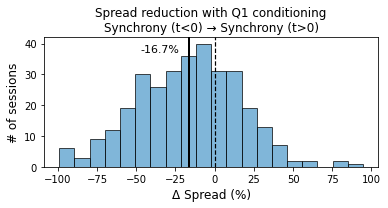

In [13]:
# Values
vals = df_spread_std["DeltaPerc_Q1_vs_Random"].dropna().values
mean_val = np.mean(vals)

fig, ax = plt.subplots(figsize=(5.5, 3))

# Histogram
ax.hist(vals, bins=20, orientation="vertical",
        color=blue_color, edgecolor="black", alpha=0.7)

# Reference lines
ax.axvline(0, color="black", linestyle="--", linewidth=1.2)
ax.axvline(mean_val, color="k", linestyle="-", linewidth=2)

# Annotate mean directly on plot
ymax = ax.get_ylim()[1]
ax.text(mean_val-18, ymax*0.87, f"{mean_val:.1f}%", 
        ha="center", va="bottom", fontsize=11, color="k")

# Labels
ax.set_xlabel("Δ Spread (%)", fontsize=12)
ax.set_ylabel("# of sessions", fontsize=12)
ax.set_title("Spread reduction with Q1 conditioning\nSynchrony (t<0) → Synchrony (t>0)", fontsize=12)

plt.tight_layout()
#plt.savefig(path_fig_out+'hdEEG_variability_hist.png', dpi=300, transparent=True)  # Transparent PNG
plt.show()


# SupplFig

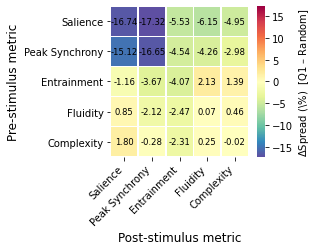

In [14]:
# ------------------------------------------------------------
# Heatmap
# ------------------------------------------------------------
A = np.nanmax(np.abs(mat))  # symmetric color scaling

plt.figure(figsize=(4.4, 3.6))
ax = sns.heatmap(
    mat, annot=True, fmt=".2f", annot_kws={"size": 8.5, "color": "black"},
    cmap="Spectral_r", vmin=-A, vmax=A, linewidths=0.5,
    cbar_kws={'label': r'$\Delta \mathrm{Spread}$ (\%)  [Q1 – Random]'}
)

ax.set_xticklabels(ordered_titles, rotation=45, ha='right')
ax.set_yticklabels(ordered_titles, rotation=0)

plt.ylabel("Pre-stimulus metric", fontsize=12)
plt.xlabel("Post-stimulus metric", fontsize=12)

plt.tight_layout()
#plt.savefig(path_fig_out+'hdEEG_variability_mat.png', dpi=300, transparent=True)  # Transparent PNG

plt.show()